# Trabalho Prático 2: Descritores de Características

### Felipe Louzada Mingote 2015033216
### Thiago Morais Araújo 2015083728

O objetivo deste trabalho é implementar o descritor de características Histogramas de Gradientes Orientados (HOG) apresentado no artigo "Histograms of Oriented Gradients for Human Detection" (em anexo a especificação) e analisar sua resposta em um conjunto de dados a ser disponibilizado.

## Imports e configurações iniciais

Neste trabalho prático foi utilizado a biblioteca `skimage` para auxiliar nas etapas intermediárias da implementação do descritor HOG, assim como em outras utilidades secundárias como IO de imagens e visualizações.

Além disso, conforme estabelecido pelo enunciado, também foi utilizada a biblioteca `sklearn` para realizar a visualização de dados em alta dimensionalidade com o `t-SNE`.  

In [27]:
import os
from matplotlib import pyplot as plt
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np

from skimage import draw
from skimage.io import imread
from skimage.feature import daisy, hog
from skimage.transform import resize
from sklearn.manifold import TSNE

## Carregamento de dados

Para facilitar o carregamento dos dados com suas respectivas classes, foi criado uma classe `DataLoader`. Os métodos implementados na classe contem uma descrição curta de suas funcionalidades tal como a explicação dos parâmetros esperados e de seu retorno quando os mesmos existem.

In [28]:
database_root = Path('fashion_mnist_sample')

In [29]:
class DataLoader(object):
    def __init__(self, root_dir: Path) -> None:
        """Construtor da classe DataLoader

        Parâmetros:
        ----------
            - root_dir : Path
                Diretório raíz da base de dados.
        """
        self.root_dir = root_dir
        self.data = []

    def __len__(self) -> int:
        """Tamanho do dataset.

        Retorno:
        -------
            - length : int
                Tamanho do dataset.
        """
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple:
        """Obtém um item do dataset.

        Parâmetros:
        ----------
            - idx : int
                Índice do dataset.

        Retorno:
        -------
            - sample : Tuple
                Tupla contendo a imagem e o rótulo.
        """
        assert idx < self.__len__(), IndexError(
            f'idx deve ser < {self.__len__()}, mas recebeu {idx}'
        )
        return self.data[idx]

    def _load_data(self) -> None:
        """Carrega os dados do dataset."""
        for image_path in self.root_dir.rglob('*.png'):
            image = imread(image_path)
            target = image_path.as_posix().split(os.sep)[-2]
            self.data.append((image, target))


In [30]:
fmnist_ds = DataLoader(database_root)
fmnist_ds._load_data()

In [31]:
image, target = fmnist_ds[0]
print(f'{target} com shape: {image.shape}')

Ankle Boot com shape: (28, 28)


## Histogram of Oriented Gradients



In [32]:
def HOGImage(image: np.ndarray, w: int, h: int, s: int, **kwargs: Dict) -> List[float]:
    """Implementação do descritor Histogram of Oriented Gradients.

    Parâmetros:
    ----------
        - image : (M, N) ndarray:
            Imagem de entrada em escala de cinza.

        - w : int
            Largura da região em pixels.

        - h : int
            Altura da região em pixels.

        - s : int
            Passo da janela em pixels.

    Retorno:
    -------
        - features : (D,) ndarray
            Vetor de características.
    """
    verbose = kwargs.get('verbose', False)
    
    if verbose:
        print('Imagem original')
        plt.axis('off')
        plt.imshow(image, cmap='gray')
        plt.show()

    # Computa o gradiente da imagem
    gx = np.zeros(image.shape)
    gy = np.zeros(image.shape)
    gx[:, :-1] = np.diff(image, n=1, axis=1)  # Derivada em x
    gy[:-1, :] = np.diff(image, n=1, axis=0)  # Derivada em y

    if verbose:
        print('Gradiente em x')
        plt.axis('off')
        plt.imshow(gx, cmap='gray')
        plt.show()
        
        print('Gradiente em y')
        plt.axis('off')
        plt.imshow(gy, cmap='gray')
        plt.show()

    # Computa a magnitude e a orientação do gradiente
    magnitude = np.sqrt(gx ** 2 + gy ** 2)
    orientation = np.arctan2(gy, (gx + 1e-15)) * (180 / np.pi) % 180

    if verbose:
        print('Magnitude')
        plt.axis('off')
        plt.imshow(magnitude, cmap='gray')
        plt.show()

        print('Orientação')
        plt.axis('off')
        plt.imshow(orientation, cmap='gray')
        plt.show()

    # Computa o histograma de orientações
    s_row, s_col = image.shape
    n_cells_row = (s_row - h) // s + 1  # Quantidade de células na vertical
    n_cells_col = (s_col - w) // s + 1  # Quantidade de células na horizontal

    # Computa o histograma de orientações para cada célula
    def find_bin(angle: int) -> int:
        """Encontra o bin de um ângulo.
        
        Parâmetros:
        ----------
            - angle : int
                Ângulo em graus.
                
        Retorno:
        -------
            - bin : int
                Bin do ângulo.
        """
        return int(np.floor((angle / 20) - .5))    # Subtraímos .5 para que o ângulo 180 seja mapeado para o bin 8

    def get_bin_value(magnitude: int, angle: int, bin: int) -> float:
        """Computa o valor do bin de um ângulo.
        
        Parâmetros:
        ----------
            - magnitude : int
                Magnitude do gradiente.
                
            - angle : int
                Ângulo em graus.
                
            - bin : int
                Bin do ângulo.
                
        Retorno:
        -------
            - value : float
                Valor do bin.
        """
        return magnitude * (1 - abs(angle - (bin * 20 + 10)) / 20)

    orientation_histogram = np.zeros((n_cells_row, n_cells_col, 9))
    for i in range(n_cells_row):
        for j in range(n_cells_col):
            cell_magnitude = magnitude[i * s:i * s + h, j * s:j * s + w]
            cell_orientation = orientation[i * s:i * s + h, j * s:j * s + w]
            for k in range(len(cell_magnitude)):
                for l in range(len(cell_magnitude[0])):
                    bin = find_bin(cell_orientation[k][l])
                    bin_value = get_bin_value(cell_magnitude[k][l], cell_orientation[k][l], bin)
                    orientation_histogram[i][j][bin] += bin_value

    if verbose:
        print('Histograma de orientações')
        print(orientation_histogram.shape)

    # Imagem HOG baseado no código da biblioteca skimage
    if verbose:
        radius = min(h, w) // 2 - 1
        orientations_arr = np.arange(9)
        # Orientação central de cada bin
        orientation_bin_midpoints = (
            np.pi * (orientations_arr + .5) / 9)
        dr_arr = radius * np.sin(orientation_bin_midpoints)  # Deslocamento em x
        dc_arr = radius * np.cos(orientation_bin_midpoints)  # Deslocamento em y
        hog_image = np.zeros(image.shape)
        for r in range(n_cells_row):
            for c in range(n_cells_col):
                for o, dr, dc in zip(orientations_arr, dr_arr, dc_arr):
                    center = tuple([r * h + h // 2,
                                    c * w + w // 2])
                    # Desenha uma linha do centro da célula até o ponto de extremidade
                    rr, cc = draw.line(int(center[0] - dc),
                                        int(center[1] + dr),
                                        int(center[0] + dc),
                                        int(center[1] - dr))
                    hog_image[rr, cc] += orientation_histogram[r, c, o]

        print('Imagem HOG')
        plt.axis('off')
        plt.imshow(hog_image, cmap='gray')
        plt.show()

    # Computa o histograma de orientações normalizado
    eps = 1e-7
    normalized_blocks = []
    for i in range(n_cells_row - 1):
        for j in range(n_cells_col - 1):
            block = orientation_histogram[i:i + 2, j:j + 2, :]   # Utiliza 2x2 blocos vizinhos
            normalized_blocks.append(block / np.sqrt(block.sum() ** 2 + eps))

    if verbose:
        print('Histograma de orientações normalizado')
        print(len(normalized_blocks))

    # Computa o vetor de características
    features = []
    for block in normalized_blocks:
        features.extend(block.ravel())

    return np.array(features)

Imagem original


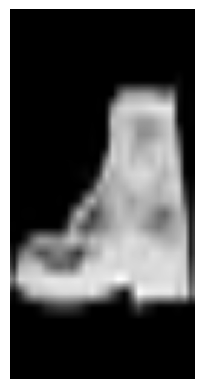

Gradiente em x


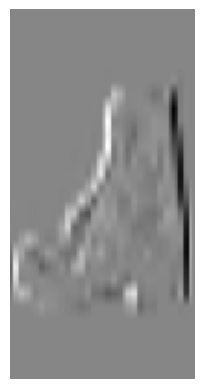

Gradiente em y


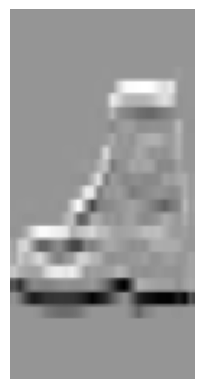

Magnitude


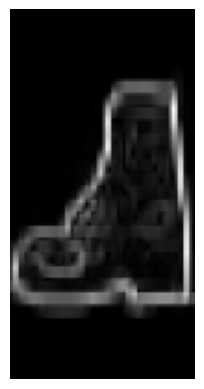

Orientação


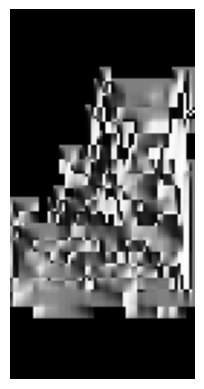

Histograma de orientações
(16, 8, 9)
Imagem HOG


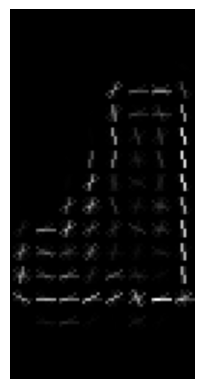

Histograma de orientações normalizado
105
(3780,)


In [33]:
feats = HOGImage(resize(image, (128, 64)), 8, 8, 8, **{'verbose': True})
print(feats.shape)

## Comparando resultados com implementação do `skimage`

Para fins de conferência do resultado obtido, foi utilizado a implementação do HOG fornecida pelo `skimage` para obter comparar o resultado implementado com o esperado de uma segunda implementação já validada.

(3780,)


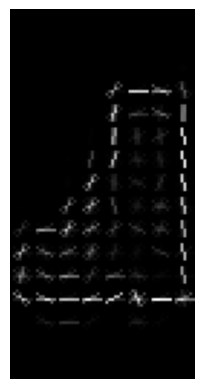

In [34]:
fd, hog_image = hog(resize(image, (128, 64)), orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True)

print(fd.shape)
plt.axis('off')
plt.imshow(hog_image, cmap='gray')
plt.show()

In [35]:
print('Diferença entre as duas implementações')
print(np.sum(np.abs(feats - fd)))

Diferença entre as duas implementações
207.484332183887


## Visualizando as HOG features usando t-SNE

Nesta etapa, conforme solicitado na descrição do trabalho prático, foi utilizado o método de visualização de dados em alta dimensionalidade [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) implementado pela biblioteca `scikit-learn`. Para a visualização dos dados, foram utilizadas as classes *Pullover*, *Sandal* e *Trouser*.

In [36]:
def get_idx(unformatted_label: str) -> int:
    """Retorna o índice de uma classe.

    Parâmetros:
    ----------
        unformatted_label : str
            Label não formatado vindo da função scatter do matplotlib.

    Retorno:
    -------
        idx: int
            Índice da classe
    """
    return int(unformatted_label.split('{')[1].split('}')[0])

(300, 3780)


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


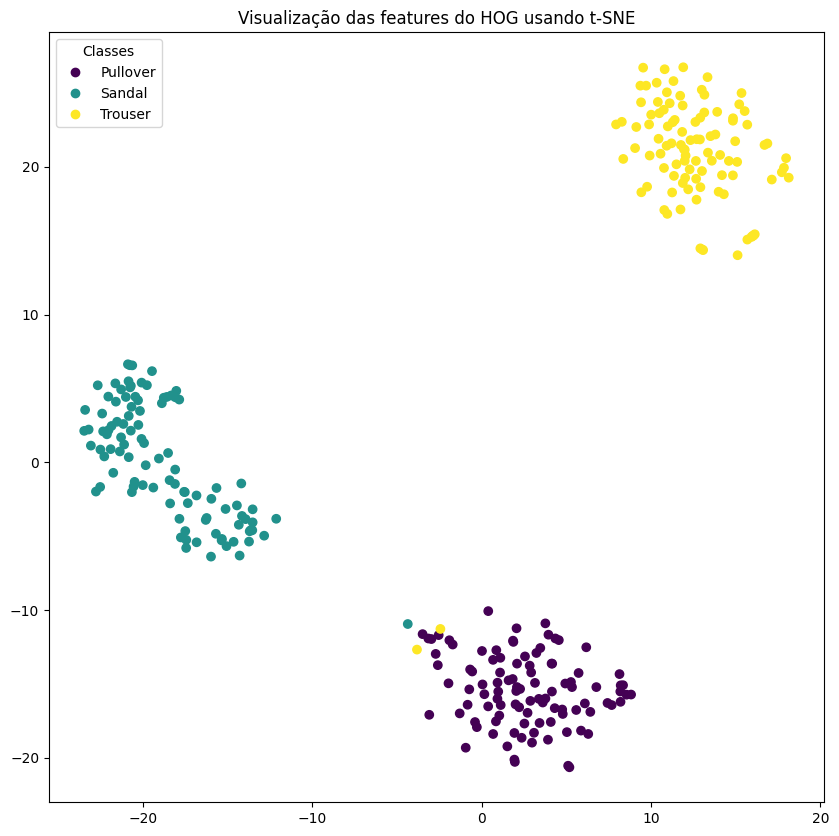

In [37]:
# Selecionando todas as imagens das classes Pullover, Sandal e Trouser
samples = []
for idx in range(len(fmnist_ds)):
    image, label = fmnist_ds[idx]
    if label == 'Pullover' or label == 'Sandal' or label == 'Trouser':
        samples.append((image, label))

# Extraindo as características HOG de cada imagem
features = []
for image, label in samples:
    features.append(HOGImage(resize(image, (128, 64)), 8, 8, 8))

features = np.array(features)

print(features.shape)

# Visualizando as features do HOG de cada imagem usando t-SNE
tsne = TSNE(n_components=2, random_state=0)
Y = tsne.fit_transform(features)   # Reduz a dimensionalidade para 2D

classes = ['Pullover', 'Sandal', 'Trouser']
colors = {cl: i for i, cl in enumerate(classes)}

plt.figure(figsize=(10, 10))
plt.title('Visualização das features do HOG usando t-SNE')
scatter = plt.scatter(Y[:, 0], Y[:, 1], c=[colors[label] for _, label in samples])

handles, labels = scatter.legend_elements(prop='colors')
plt.legend(handles, [classes[get_idx(l)] for l in labels], loc='best', title='Classes')

plt.show()


Como é possível observar, o descritor HOG conseguiu gerar features altamente separáveis das classes selecionadas. Salvo apenas 3 exceções em que as features obtidas para imagens das classes *Sandal* e *Trouser* se misturam na região espacial correspondente a classe *Pullover*.

É esperado que pelo formato das imagens o descritor seja capaz de gerar histogramas bem distintos umas vez que a distribuição das bordas destas imagens são distribuídas espacialmente de maneira distinta.

## Comparando o HOG com Daisy
Por fim, a descrição do trabalho solicita como última tarefa a comparação do método HOG implementado com um outro descritor de características já implementado. Neste trabalho foi escolhido o descritor [Daisy](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.daisy) também implementado pela biblioteca `skimage`. A escolha o descritor se deu pela extração de características de forma densa na imagem, uma vez que o dataset é extremamente simples.

Para a comparação dos dois descritores, foi extraído o vetor de features de toda a base de dados e então projetado para visualização usando novamente o t-SNE.

In [ ]:
hog_features = []
daisy_features = []

for idx in range(len(fmnist_ds)):
    image, label = fmnist_ds[idx]
    image = resize(image, (128, 64))
    hog_features.append(HOGImage(image, 8, 8, 8))
    daisy_features.append(daisy(image, step=8, radius=8, rings=2, histograms=6, orientations=8).flatten())

hog_features = np.array(hog_features)
daisy_features = np.array(daisy_features)

print(hog_features.shape)
print(daisy_features.shape)

classes = ['Ankle Boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']
colors = {cl: i for i, cl in enumerate(classes)}

# Visualizando as features do HOG de cada imagem usando t-SNE
tsne = TSNE(n_components=2, random_state=0)
Y = tsne.fit_transform(hog_features)

plt.figure(figsize=(10, 10))
plt.title('Visualização das features do HOG usando t-SNE')
scatter = plt.scatter(Y[:, 0], Y[:, 1], c=[colors[fmnist_ds[idx][1]] for idx in range(len(fmnist_ds))], cmap='tab10')

handles, labels = scatter.legend_elements(prop='colors')
plt.legend(handles, [classes[get_idx(l)] for l in labels], loc='best', title='Classes')

plt.show()

# Visualizando as features do Daisy de cada imagem usando t-SNE
tsne = TSNE(n_components=2, random_state=0)
Y = tsne.fit_transform(daisy_features)

plt.figure(figsize=(10, 10))
plt.title('Visualização das features do Daisy usando t-SNE')
plt.scatter(Y[:, 0], Y[:, 1], c=[colors[fmnist_ds[idx][1]] for idx in range(len(fmnist_ds))], cmap='tab10')

handles, labels = scatter.legend_elements(prop='colors')
plt.legend(handles, [classes[get_idx(l)] for l in labels], loc='best', title='Classes')

plt.show()

Como podemos observar, algumas classes são mais facilmente separadas das demais independente do descritor utilizado para extração dos vetores de características, como as classes *Trouser*, e *Bag*. A principal hipótese para que isso ocorra é a discrepância no *shape* das instâncias dessas classes em relação ao restante do dataset.

Em contrapartida, independente do descritor utilizado, algumas classes sempre se misturam como é possível observar para os conjuntos compostos por *Ankle Boot* e *Sandal* (calçados), e *Shirt*, *Coat*, *Pullover* (vestimentas). Ao observar as instâncias que compõem tais conjuntos é possível perceber que os objetos que compõem tais classes possuem uma grande semelhança de formato entre si.

Finalmente, apesar de visualmente os dois descritores apresentarem uma capacidade de separabilidade similar entre as classes presentes na base de dados, o Daisy parece ser mais promissor em termos de generalização de um possível modelo de *Machine Learning* treinado utilizando as features extraídas. Isso se deve ao fato de os grupos pertencentes a mesma classe serem mais coesos, e portanto, há menor chance de confusão do classificador entre classes distintas. É claro que para os exemplos citados anteriormente, onde as classes se confundem no espaço de visualização ainda exista a possibilidade de o classificador não ser capaz de generalizar bem.